In [24]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (6,4)
torch.manual_seed(42)
np.random.seed(42)

In [25]:
DATA_DIR = "/home/arjbah/Desktop/Coursework/ML/datasets/MTAT"
MP3_DIR = os.path.join(DATA_DIR, "mp3")
ANN_PATH = os.path.join(DATA_DIR, "annotations_final.csv")
CLIP_INFO_PATH = os.path.join(DATA_DIR, "clip_info_final.csv")
PREPROC_DIR = os.path.join(DATA_DIR, "preproc")

MODEL_DIR = "/home/arjbah/Desktop/Coursework/ML/Lab3"
LOGS_DIR = os.path.join(MODEL_DIR, "logs")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Base dir: {DATA_DIR}")
print(f"Using device: {device}")

Base dir: /home/arjbah/Desktop/Coursework/ML/datasets/MTAT
Using device: cuda


### Create Genre Heirarchy

In [26]:
GENRE_HIERARCHY = {
    'rock': ['rock', 'hard rock', 'soft rock', 'punk', 'metal', 'heavy metal'],
    'classical': ['classical', 'clasical', 'opera', 'baroque', 'medieval', 'operatic'],
    'electronic': ['electronic', 'electro', 'electronica', 'techno', 'trance', 
                   'house', 'disco', 'industrial', 'ambient', 'new age'],
    'jazz_blues': ['jazz', 'jazzy', 'blues', 'funk', 'funky'],
    'folk_country': ['folk', 'country', 'celtic', 'irish'],
    'urban': ['hip hop', 'rap', 'reggae'],
    'world': ['world', 'indian', 'india', 'arabic', 'middle eastern', 'eastern', 
              'oriental', 'spanish', 'tribal']
}

print("Hierarchical Genre Structure:")
for parent, children in GENRE_HIERARCHY.items():
    print(f"  {parent}: {len(children)} sub-genres")

Hierarchical Genre Structure:
  rock: 6 sub-genres
  classical: 6 sub-genres
  electronic: 10 sub-genres
  jazz_blues: 5 sub-genres
  folk_country: 4 sub-genres
  urban: 3 sub-genres
  world: 9 sub-genres


### Load and Filter Data for Genre Tags

In [27]:
ann = pd.read_csv(ANN_PATH, sep="\t", quotechar='"', engine='c')
print(f"\nOriginal annotation shape: {ann.shape}")
print(f"Total tags: {ann.shape[1] - 2}")  # -2 for clip_id and mp3_path


Original annotation shape: (25863, 190)
Total tags: 188


### Create genre labels

In [28]:
def create_hierarchical_labels(ann_df, hierarchy):
    """
    Create hierarchical genre labels by combining related tags
    A sample has a parent genre if ANY of its child tags are present
    """
    new_labels = pd.DataFrame(index=ann_df.index)
    
    for parent_genre, child_tags in hierarchy.items():
        # Find which child tags exist in the dataset
        available_tags = [tag for tag in child_tags if tag in ann_df.columns]
        if available_tags:
            # Sample has parent genre if ANY child tag is present (max across row)
            new_labels[parent_genre] = ann_df[available_tags].max(axis=1)
        else:
            new_labels[parent_genre] = 0
    
    return new_labels

# Create genre labels
genre_labels = create_hierarchical_labels(ann, GENRE_HIERARCHY)
selected_tags = list(GENRE_HIERARCHY.keys())

print("\n" + "=" * 60)
print("GENRE LABEL CREATION")
print("=" * 60)
print(f"Number of hierarchical genres: {len(selected_tags)}")
print(f"Genres: {selected_tags}")


GENRE LABEL CREATION
Number of hierarchical genres: 7
Genres: ['rock', 'classical', 'electronic', 'jazz_blues', 'folk_country', 'urban', 'world']


### Combine with metadata

In [29]:
# Calculate genre sum
genre_sum = genre_labels.sum(axis=1)
has_genre = genre_sum > 0

# Filter out samples with no genre tags
filtered_ann = pd.concat([
    ann.loc[has_genre, ['clip_id', 'mp3_path']].reset_index(drop=True),
    genre_labels[has_genre].reset_index(drop=True)
], axis=1)

print(f"\nSamples with at least one genre tag: {has_genre.sum()} / {len(ann)}")
print(f"Average genres per sample: {genre_sum[has_genre].mean():.2f}")


Samples with at least one genre tag: 15316 / 25863
Average genres per sample: 1.11


### Show genre distribution


GENRE DISTRIBUTION
  electronic          :  5500 (35.91%)
  classical           :  5206 (33.99%)
  rock                :  2415 (15.77%)
  world               :  1902 (12.42%)
  folk_country        :   893 ( 5.83%)
  jazz_blues          :   876 ( 5.72%)
  urban               :   162 ( 1.06%)


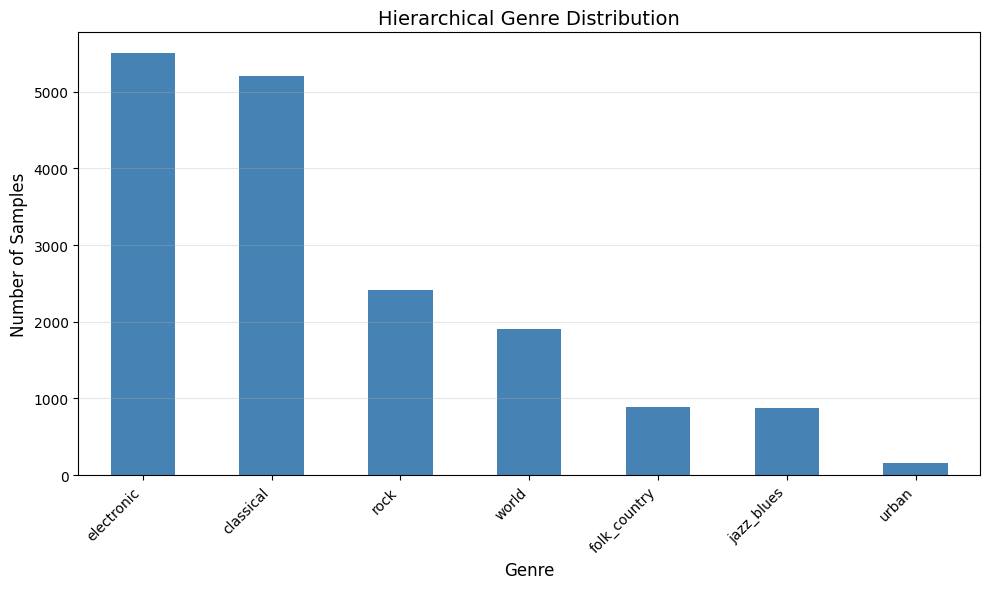

In [30]:
print("\n" + "=" * 60)
print("GENRE DISTRIBUTION")
print("=" * 60)

genre_counts = genre_labels[has_genre].sum(axis=0).sort_values(ascending=False)
for genre, count in genre_counts.items():
    percentage = (count / has_genre.sum()) * 100
    print(f"  {genre:20s}: {int(count):5d} ({percentage:5.2f}%)")

# Plot 
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='steelblue')
plt.title('Hierarchical Genre Distribution', fontsize=14,)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Functions for computing spectrograms

In [31]:
def compute_mel_spectrogram(audio_path, sr=16000, duration=20, n_mels=80, target_frames=646):
    """Compute normalized mel spectrogram with fixed dimensions."""
    target_length = int(sr * duration)

    try:
        # Load and pad/truncate audio
        y, sr = librosa.load(audio_path, sr=sr, duration=duration, mono=True)
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]

        # Compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=n_mels, n_fft=2048, hop_length=1024
        )

        # Pad/truncate time dimension
        if mel_spec.shape[1] < target_frames:
            mel_spec = np.pad(mel_spec, ((0, 0), (0, target_frames - mel_spec.shape[1])), mode='constant')
        else:
            mel_spec = mel_spec[:, :target_frames]

        # Convert to log scale and normalize
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-6)

        return mel_spec_db

    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return np.zeros((n_mels, target_frames))


def precompute_spectrograms(file_paths, labels, save_dir, split_name,
                            sr=16000, duration=20, n_mels=80, target_frames=646,
                            use_memmap=None):
    """
    Pre-compute and save spectrograms for a data split.
    """
    # Auto-detect storage method
    if use_memmap is None:
        use_memmap = len(file_paths) > 10000
    
    # Define save paths
    if use_memmap:
        spec_path = os.path.join(save_dir, f"{split_name}_specs.npy")
        labels_path = os.path.join(save_dir, f"{split_name}_labels.npy")
    else:
        save_path = os.path.join(save_dir, f"{split_name}.npz")
    
    # Check if already exists
    if use_memmap:
        exists = os.path.exists(spec_path) and os.path.exists(labels_path)
    else:
        exists = os.path.exists(save_path)
    
    if exists:
        response = input(f"{split_name.title()} spectrograms already exist. Recompute? (y/n): ").lower()
        if response != 'y':
            print(f"Loading existing {split_name} data")
            if use_memmap:
                return np.load(spec_path, mmap_mode='r'), np.load(labels_path)
            else:
                data = np.load(save_path)
                return data['spectrograms'], data['labels']
    
    # Process spectrograms
    print(f"\nPreprocessing {split_name} set: {len(file_paths)} files")
    if use_memmap:
        print("Using memory-mapped approach for large dataset")
    
    if use_memmap:
        # Memory-mapped approach for large datasets
        shape = (len(file_paths), n_mels, target_frames)
        spectrograms = np.lib.format.open_memmap(spec_path, mode='w+', dtype=np.float16, shape=shape)
        
        for i, audio_path in enumerate(file_paths):
            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(file_paths)} ({(i+1)/len(file_paths)*100:.1f}%)")
            spectrograms[i] = compute_mel_spectrogram(audio_path, sr, duration, n_mels, target_frames)
        
        del spectrograms
        labels_array = np.array(labels, dtype=np.float16)
        np.save(labels_path, labels_array)
        spectrograms = np.load(spec_path, mmap_mode='r')
        
        print(f"  Saved to {spec_path} ({os.path.getsize(spec_path) / 1e6:.1f} MB)")
        
    else:
        # Chunked approach for smaller datasets
        chunk_size = 1000
        all_spectrograms = []
        
        for start_idx in range(0, len(file_paths), chunk_size):
            end_idx = min(start_idx + chunk_size, len(file_paths))
            chunk_specs = []
            
            for i in range(start_idx, end_idx):
                if (i + 1) % 100 == 0:
                    print(f"  Processed {i + 1}/{len(file_paths)} ({(i+1)/len(file_paths)*100:.1f}%)")
                chunk_specs.append(compute_mel_spectrogram(file_paths[i], sr, duration, n_mels, target_frames))
            
            all_spectrograms.append(np.array(chunk_specs, dtype=np.float16))
            del chunk_specs
        
        spectrograms = np.concatenate(all_spectrograms, axis=0)
        labels_array = np.array(labels, dtype=np.float16)
        
        np.savez_compressed(save_path, spectrograms=spectrograms, labels=labels_array)
        print(f"  Saved to {save_path} ({os.path.getsize(save_path) / 1e6:.1f} MB)")
    
    print(f"  Spectrograms shape: {spectrograms.shape}")
    return spectrograms, labels_array

### Dataloader

In [32]:
# %% Dataset Class
class PreprocessedAudioDataset(Dataset):
    """Dataset for loading preprocessed spectrograms"""

    def __init__(self, spectrograms, labels):
        self.spectrograms = spectrograms
        self.labels = labels

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        spec = self.spectrograms[idx].copy()[np.newaxis, ...]  # (1, n_mels, time)
        label = self.labels[idx].copy()
        return torch.FloatTensor(spec), torch.FloatTensor(label)


def prepare_data(ann_df, selected_tags, test_size=0.15, val_size=0.15, random_state=42):
    """
    Prepare train, validation, and test splits with multi-hot encoded labels
    """
    labels_list = []
    valid_indices = []

    for idx, row in ann_df.iterrows():
        present_tags = [tag for tag in selected_tags if tag in row.index and row[tag] == 1]
        labels_list.append(present_tags)
        valid_indices.append(idx)

    # Multi-hot encode labels
    mlb = MultiLabelBinarizer(classes=selected_tags)
    mlb.fit([selected_tags])
    labels_encoded = mlb.transform(labels_list)

    # Get file paths
    file_paths = [os.path.join(MP3_DIR, ann_df.loc[idx, 'mp3_path']) for idx in valid_indices]

    print(f"\n{'='*60}")
    print("PREPARING DATA SPLITS")
    print(f"{'='*60}")
    print(f"Total samples: {len(file_paths)}")
    print(f"Label shape: {labels_encoded.shape}")
    print(f"Average genres per sample: {labels_encoded.sum(axis=1).mean():.2f}")

    # Split: train, temp (for val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        file_paths, labels_encoded, test_size=(test_size + val_size),
        random_state=random_state, shuffle=True
    )

    # Split temp into validation and test
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_ratio),
        random_state=random_state, shuffle=True
    )

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    return X_train, X_val, X_test, y_train, y_val, y_test

### Prepare the data

In [33]:

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    filtered_ann, selected_tags, test_size=0.15, val_size=0.15
)

# Preprocess spectrograms
print("\n" + "=" * 60)
print("PREPROCESSING SPECTROGRAMS")
print("=" * 60)

spec_train, labels_train = precompute_spectrograms(
    X_train, y_train, PREPROC_DIR, "train"
)
spec_val, labels_val = precompute_spectrograms(
    X_val, y_val, PREPROC_DIR, "val"
)
spec_test, labels_test = precompute_spectrograms(
    X_test, y_test, PREPROC_DIR, "test"
)

# Create datasets and dataloaders   
train_dataset = PreprocessedAudioDataset(spec_train, labels_train)
val_dataset = PreprocessedAudioDataset(spec_val, labels_val)
test_dataset = PreprocessedAudioDataset(spec_test, labels_test)


print("\n" + "=" * 60)
print("CREATING DATALOADERS")
print("=" * 60)

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

# Get input size
sample_input, _ = next(iter(train_loader))
input_size = sample_input.view(sample_input.size(0), -1).shape[1]
num_classes = len(selected_tags)

print(f"\nInput size: {input_size}")
print(f"Number of genre classes: {num_classes}")
print(f"Input tensor shape: {sample_input.shape}")


PREPARING DATA SPLITS
Total samples: 15316
Label shape: (15316, 7)
Average genres per sample: 1.11
Train: 10721, Val: 2297, Test: 2298

PREPROCESSING SPECTROGRAMS


Train spectrograms already exist. Recompute? (y/n):  n


Loading existing train data


Val spectrograms already exist. Recompute? (y/n):  n


Loading existing val data


Test spectrograms already exist. Recompute? (y/n):  n


Loading existing test data

CREATING DATALOADERS
Batch size: 32
Train batches: 336, Val: 72, Test: 72

Input size: 51680
Number of genre classes: 7
Input tensor shape: torch.Size([32, 1, 80, 646])


### Model definitions

In [34]:
class MLPBaseline(nn.Module):
    """MLP Baseline Model"""

    def __init__(self, input_size, hidden_sizes, num_classes, dropout=0.3):
        super(MLPBaseline, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


class CNN(nn.Module):
    """CNN Model for Audio Classification"""

    def __init__(self, num_classes, dropout=0.3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

### Training functions

In [35]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            all_outputs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)

    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)

    try:
        roc_auc = roc_auc_score(all_labels, all_outputs, average='macro')
    except ValueError:
        roc_auc = 0.0

    return epoch_loss, roc_auc


def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, num_epochs=20, model_name="Model"):
    """Full training loop"""
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': []
    }

    best_val_auc = 0.0
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_auc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)

        log_line = f"{model_name} | Epoch {epoch+1}/{num_epochs} | " \
               f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val AUC: {val_auc:.3f}"

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), f'{model_name}.pth')
            log_line += " | New best model!"
    
        print(log_line)

    return history

### Plotting functions

In [36]:
def plot_training_history(history_mlp, history_cnn, save_dir):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(history_mlp['train_loss'], label='MLP Train', marker='o')
    axes[0].plot(history_mlp['val_loss'], label='MLP Val', marker='o')
    axes[0].plot(history_cnn['train_loss'], label='CNN Train', marker='s')
    axes[0].plot(history_cnn['val_loss'], label='CNN Val', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # AUC plot
    axes[1].plot(history_mlp['val_auc'], label='MLP', marker='o')
    axes[1].plot(history_cnn['val_auc'], label='CNN', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('ROC AUC')
    axes[1].set_title('Validation ROC AUC')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'training_comparison.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Training comparison plot saved to: {save_path}")
    plt.show()


def plot_individual_metrics(history, model_name, save_dir):
    """Plot individual model metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history['train_loss'], label='Train Loss', marker='o', color='blue')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='o', color='orange')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history['val_auc'], label='Val AUC', marker='o', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('ROC AUC')
    axes[1].set_title(f'{model_name} - Validation AUC')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    save_path = os.path.join(save_dir, f'{model_name}_metrics.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"{model_name} metrics plot saved to: {save_path}")
    plt.show()


def save_results_summary(history_mlp, history_cnn, mlp_test_auc, cnn_test_auc,
                        mlp_test_loss, cnn_test_loss, save_dir, selected_tags):
    """Save a text summary of results"""
    summary_path = os.path.join(save_dir, 'genre_results_summary.txt')

    with open(summary_path, 'w') as f:
        f.write("=" * 60 + "\n")
        f.write("HIERARCHICAL GENRE CLASSIFICATION RESULTS\n")
        f.write("=" * 60 + "\n\n")

        f.write("Dataset: MagnaTagATune (Genre Tags Only)\n")
        f.write(f"Number of genre categories: {len(selected_tags)}\n")
        f.write(f"Genres: {', '.join(selected_tags)}\n")
        f.write(f"Metric: ROC AUC (macro-averaged)\n\n")

        f.write("-" * 60 + "\n")
        f.write("MLP BASELINE RESULTS\n")
        f.write("-" * 60 + "\n")
        f.write(f"Best Validation AUC: {max(history_mlp['val_auc']):.4f} (Epoch {np.argmax(history_mlp['val_auc'])+1})\n")
        f.write(f"Final Validation AUC: {history_mlp['val_auc'][-1]:.4f}\n")
        f.write(f"Test AUC: {mlp_test_auc:.4f}\n")
        f.write(f"Test Loss: {mlp_test_loss:.4f}\n\n")

        f.write("-" * 60 + "\n")
        f.write("CNN RESULTS\n")
        f.write("-" * 60 + "\n")
        f.write(f"Best Validation AUC: {max(history_cnn['val_auc']):.4f} (Epoch {np.argmax(history_cnn['val_auc'])+1})\n")
        f.write(f"Final Validation AUC: {history_cnn['val_auc'][-1]:.4f}\n")
        f.write(f"Test AUC: {cnn_test_auc:.4f}\n")
        f.write(f"Test Loss: {cnn_test_loss:.4f}\n\n")

        f.write("-" * 60 + "\n")
        f.write("COMPARISON\n")
        f.write("-" * 60 + "\n")
        improvement = ((cnn_test_auc - mlp_test_auc) / mlp_test_auc * 100)
        f.write(f"CNN vs MLP Improvement: {improvement:+.2f}%\n")
        f.write(f"Absolute Difference: {cnn_test_auc - mlp_test_auc:+.4f}\n")

    print(f"\nResults summary saved to: {summary_path}")

### Run training


TRAINING MLP BASELINE
MLP | Epoch 1/30 | Train Loss: 0.408 | Val Loss: 0.313 | Val AUC: 0.755 | New best model!
MLP | Epoch 2/30 | Train Loss: 0.346 | Val Loss: 0.304 | Val AUC: 0.764 | New best model!
MLP | Epoch 3/30 | Train Loss: 0.333 | Val Loss: 0.307 | Val AUC: 0.789 | New best model!
MLP | Epoch 4/30 | Train Loss: 0.335 | Val Loss: 0.323 | Val AUC: 0.739
MLP | Epoch 5/30 | Train Loss: 0.330 | Val Loss: 0.301 | Val AUC: 0.773
MLP | Epoch 6/30 | Train Loss: 0.335 | Val Loss: 0.317 | Val AUC: 0.760
MLP | Epoch 7/30 | Train Loss: 0.338 | Val Loss: 0.313 | Val AUC: 0.718
MLP | Epoch 8/30 | Train Loss: 0.334 | Val Loss: 0.307 | Val AUC: 0.767
MLP | Epoch 9/30 | Train Loss: 0.336 | Val Loss: 0.302 | Val AUC: 0.756
MLP | Epoch 10/30 | Train Loss: 0.338 | Val Loss: 0.319 | Val AUC: 0.743
MLP | Epoch 11/30 | Train Loss: 0.352 | Val Loss: 0.323 | Val AUC: 0.710
MLP | Epoch 12/30 | Train Loss: 0.352 | Val Loss: 0.345 | Val AUC: 0.704
MLP | Epoch 13/30 | Train Loss: 0.346 | Val Loss: 0.312 

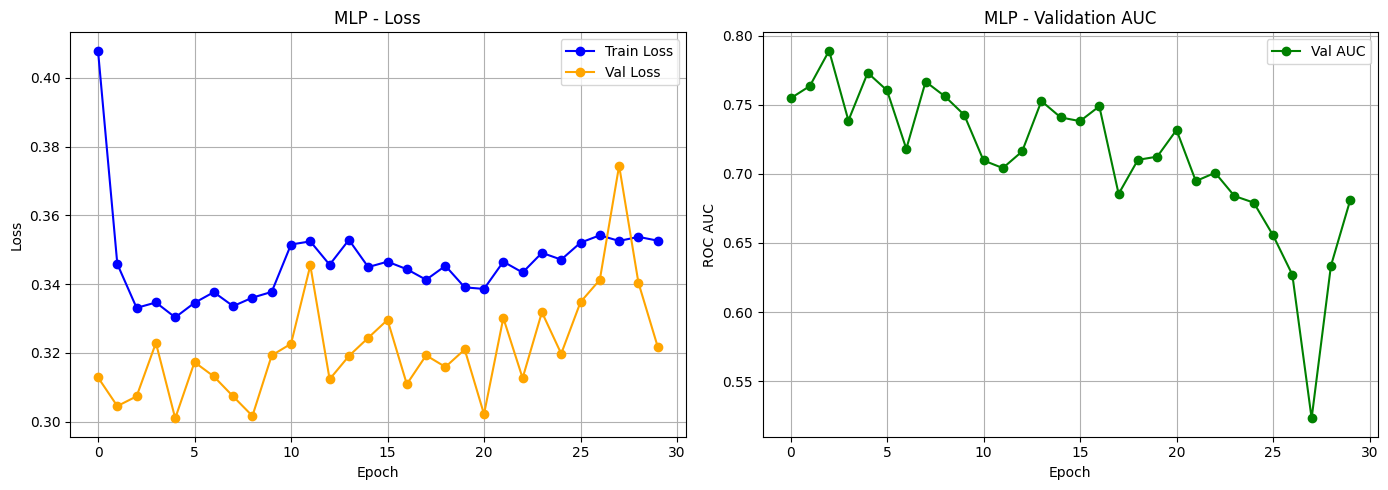


TRAINING CNN
CNN | Epoch 1/30 | Train Loss: 0.273 | Val Loss: 0.234 | Val AUC: 0.857 | New best model!
CNN | Epoch 2/30 | Train Loss: 0.220 | Val Loss: 0.203 | Val AUC: 0.916 | New best model!
CNN | Epoch 3/30 | Train Loss: 0.199 | Val Loss: 0.540 | Val AUC: 0.815
CNN | Epoch 4/30 | Train Loss: 0.193 | Val Loss: 0.313 | Val AUC: 0.873
CNN | Epoch 5/30 | Train Loss: 0.186 | Val Loss: 0.186 | Val AUC: 0.920 | New best model!
CNN | Epoch 6/30 | Train Loss: 0.181 | Val Loss: 0.180 | Val AUC: 0.921 | New best model!
CNN | Epoch 7/30 | Train Loss: 0.176 | Val Loss: 0.252 | Val AUC: 0.884
CNN | Epoch 8/30 | Train Loss: 0.169 | Val Loss: 0.171 | Val AUC: 0.933 | New best model!
CNN | Epoch 9/30 | Train Loss: 0.165 | Val Loss: 0.554 | Val AUC: 0.826
CNN | Epoch 10/30 | Train Loss: 0.163 | Val Loss: 0.145 | Val AUC: 0.941 | New best model!
CNN | Epoch 11/30 | Train Loss: 0.160 | Val Loss: 0.145 | Val AUC: 0.945 | New best model!
CNN | Epoch 12/30 | Train Loss: 0.157 | Val Loss: 0.180 | Val AUC:

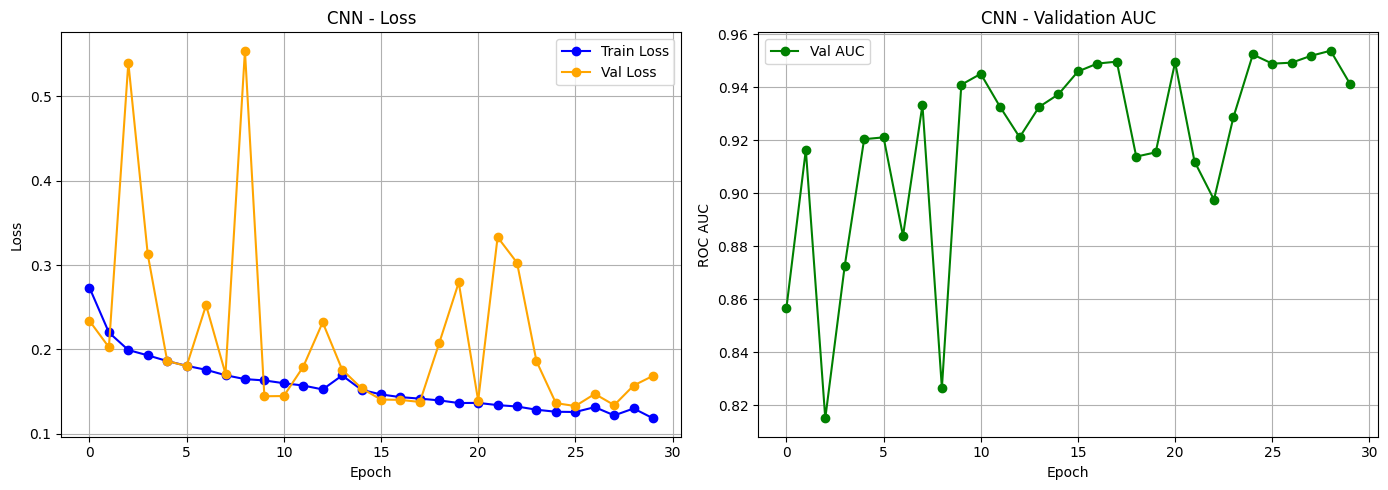

In [37]:
criterion = nn.BCEWithLogitsLoss()

# Train MLP
print("\n" + "=" * 60)
print("TRAINING MLP BASELINE")
print("=" * 60)

mlp_model = MLPBaseline(
    input_size=input_size,
    hidden_sizes=[1024, 512, 256],
    num_classes=num_classes,
    dropout=0.4
).to(device)

optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)

history_mlp = train_model(
    mlp_model, train_loader, val_loader, criterion, optimizer_mlp,
    device, num_epochs=30, model_name="MLP"
)

plot_individual_metrics(history_mlp, 'MLP', LOGS_DIR)

# Train CNN
print("\n" + "=" * 60)
print("TRAINING CNN")
print("=" * 60)

cnn_model = CNN(num_classes=num_classes, dropout=0.3).to(device)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)

history_cnn = train_model(
    cnn_model, train_loader, val_loader, criterion, optimizer_cnn,
    device, num_epochs=30, model_name="CNN"
)

plot_individual_metrics(history_cnn, 'CNN', LOGS_DIR)

### Evaluate on the test set

In [38]:
print("\n" + "=" * 60)
print("EVALUATING BEST MODEL ON TEST SET")
print("=" * 60)

# Load best models
mlp_model.load_state_dict(torch.load('MLP.pth'))
cnn_model.load_state_dict(torch.load('CNN.pth'))

# Evaluate
mlp_test_loss, mlp_test_auc = evaluate(mlp_model, test_loader, criterion, device)
cnn_test_loss, cnn_test_auc = evaluate(cnn_model, test_loader, criterion, device)

print(f"\nMLP Baseline Test Results:")
print(f"  Test Loss: {mlp_test_loss:.4f}")
print(f"  Test ROC AUC: {mlp_test_auc:.4f}")

print(f"\nCNN Test Results:")
print(f"  Test Loss: {cnn_test_loss:.4f}")
print(f"  Test ROC AUC: {cnn_test_auc:.4f}")

improvement = ((cnn_test_auc - mlp_test_auc) / mlp_test_auc * 100)
print(f"\nCNN Improvement over MLP: {improvement:+.2f}%")


EVALUATING BEST MODEL ON TEST SET

MLP Baseline Test Results:
  Test Loss: 0.3074
  Test ROC AUC: 0.7866

CNN Test Results:
  Test Loss: 0.1600
  Test ROC AUC: 0.9469

CNN Improvement over MLP: +20.38%


### Functions for per-genre evaluation

In [39]:
def evaluate_per_genre(model, dataloader, device, genre_names, threshold=0.5):
    """
    Evaluate model with per-genre metrics
    
    Returns:
        per_genre_metrics: Dictionary with metrics for each genre
        all_outputs: Predicted probabilities
        all_labels: True labels
    """
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            
            all_outputs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    
    # Calculate per-genre metrics
    per_genre_metrics = {}
    
    for idx, genre in enumerate(genre_names):
        y_true = all_labels[:, idx]
        y_pred_probs = all_outputs[:, idx]
        y_pred_binary = (y_pred_probs >= threshold).astype(int)
        
        # Calculate metrics
        n_positive = y_true.sum()
        n_negative = len(y_true) - n_positive
        
        # True Positives, False Positives, etc.
        tp = ((y_pred_binary == 1) & (y_true == 1)).sum()
        fp = ((y_pred_binary == 1) & (y_true == 0)).sum()
        tn = ((y_pred_binary == 0) & (y_true == 0)).sum()
        fn = ((y_pred_binary == 0) & (y_true == 1)).sum()
        
        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        # Accuracy
        accuracy = (tp + tn) / len(y_true)
        
        # ROC AUC (only if both classes present)
        try:
            if n_positive > 0 and n_negative > 0:
                auc = roc_auc_score(y_true, y_pred_probs)
            else:
                auc = 0.0
        except:
            auc = 0.0
        
        # Average confidence
        avg_confidence = y_pred_probs.mean()
        avg_confidence_positive = y_pred_probs[y_true == 1].mean() if n_positive > 0 else 0.0
        avg_confidence_negative = y_pred_probs[y_true == 0].mean() if n_negative > 0 else 0.0
        
        per_genre_metrics[genre] = {
            'n_samples': len(y_true),
            'n_positive': int(n_positive),
            'n_negative': int(n_negative),
            'support_ratio': n_positive / len(y_true),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'tp': int(tp),
            'fp': int(fp),
            'tn': int(tn),
            'fn': int(fn),
            'avg_confidence': avg_confidence,
            'avg_conf_positive': avg_confidence_positive,
            'avg_conf_negative': avg_confidence_negative
        }
    
    return per_genre_metrics, all_outputs, all_labels


def print_genre_metrics(metrics, model_name="Model"):
    """Print per-genre metrics in a formatted table"""
    print(f"\n{'='*100}")
    print(f"{model_name} - PER-GENRE PERFORMANCE METRICS")
    print(f"{'='*100}")
    print(f"{'Genre':<15} {'Support':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10}")
    print(f"{'-'*100}")
    
    # Sort by F1 score descending
    sorted_genres = sorted(metrics.items(), key=lambda x: x[1]['f1'], reverse=True)
    
    for genre, m in sorted_genres:
        support_str = f"{m['n_positive']}/{m['n_samples']}"
        print(f"{genre:<15} {support_str:<10} {m['accuracy']:<10.4f} {m['precision']:<10.4f} "
              f"{m['recall']:<10.4f} {m['f1']:<10.4f} {m['auc']:<10.4f}")
    
    # Print averages
    avg_acc = np.mean([m['accuracy'] for m in metrics.values()])
    avg_prec = np.mean([m['precision'] for m in metrics.values()])
    avg_rec = np.mean([m['recall'] for m in metrics.values()])
    avg_f1 = np.mean([m['f1'] for m in metrics.values()])
    avg_auc = np.mean([m['auc'] for m in metrics.values()])
    
    print(f"{'-'*100}")
    print(f"{'AVERAGE':<15} {'':<10} {avg_acc:<10.4f} {avg_prec:<10.4f} "
          f"{avg_rec:<10.4f} {avg_f1:<10.4f} {avg_auc:<10.4f}")
    print(f"{'='*100}\n")


def plot_genre_metrics(metrics_mlp, metrics_cnn, save_dir):
    """Plot per-genre comparison charts"""
    genres = list(metrics_mlp.keys())
    
    # Extract metrics for plotting
    mlp_f1 = [metrics_mlp[g]['f1'] for g in genres]
    cnn_f1 = [metrics_cnn[g]['f1'] for g in genres]
    mlp_auc = [metrics_mlp[g]['auc'] for g in genres]
    cnn_auc = [metrics_cnn[g]['auc'] for g in genres]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # F1 Score Comparison
    x = np.arange(len(genres))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, mlp_f1, width, label='MLP', alpha=0.8, color='skyblue')
    axes[0, 0].bar(x + width/2, cnn_f1, width, label='CNN', alpha=0.8, color='coral')
    axes[0, 0].set_xlabel('Genre', fontweight='bold')
    axes[0, 0].set_ylabel('F1 Score', fontweight='bold')
    axes[0, 0].set_title('F1 Score by Genre', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(genres, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # AUC Comparison
    axes[0, 1].bar(x - width/2, mlp_auc, width, label='MLP', alpha=0.8, color='skyblue')
    axes[0, 1].bar(x + width/2, cnn_auc, width, label='CNN', alpha=0.8, color='coral')
    axes[0, 1].set_xlabel('Genre', fontweight='bold')
    axes[0, 1].set_ylabel('ROC AUC', fontweight='bold')
    axes[0, 1].set_title('ROC AUC by Genre', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(genres, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Precision-Recall scatter for CNN
    cnn_precision = [metrics_cnn[g]['precision'] for g in genres]
    cnn_recall = [metrics_cnn[g]['recall'] for g in genres]
    support = [metrics_cnn[g]['n_positive'] for g in genres]
    
    scatter = axes[1, 0].scatter(cnn_recall, cnn_precision, s=[s*2 for s in support], 
                                 alpha=0.6, c=range(len(genres)), cmap='viridis')
    for i, genre in enumerate(genres):
        axes[1, 0].annotate(genre, (cnn_recall[i], cnn_precision[i]), 
                           fontsize=9, alpha=0.7)
    axes[1, 0].set_xlabel('Recall', fontweight='bold')
    axes[1, 0].set_ylabel('Precision', fontweight='bold')
    axes[1, 0].set_title('CNN: Precision vs Recall (bubble size = support)', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(-0.05, 1.05)
    axes[1, 0].set_ylim(-0.05, 1.05)
    
    # Improvement heatmap (CNN vs MLP)
    improvements = {
        'F1': [cnn_f1[i] - mlp_f1[i] for i in range(len(genres))],
        'AUC': [cnn_auc[i] - mlp_auc[i] for i in range(len(genres))],
        'Precision': [metrics_cnn[g]['precision'] - metrics_mlp[g]['precision'] for g in genres],
        'Recall': [metrics_cnn[g]['recall'] - metrics_mlp[g]['recall'] for g in genres]
    }
    
    improvement_df = pd.DataFrame(improvements, index=genres)
    sns.heatmap(improvement_df.T, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
                ax=axes[1, 1], cbar_kws={'label': 'Improvement'})
    axes[1, 1].set_title('CNN vs MLP Improvement by Genre', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Genre', fontweight='bold')
    axes[1, 1].set_ylabel('Metric', fontweight='bold')
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, 'genre_metrics_comparison.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Genre metrics comparison saved to: {save_path}")
    plt.show()


def plot_confusion_heatmap(outputs, labels, genre_names, model_name, save_dir):
    """Plot genre co-occurrence and confusion patterns"""
    # Genre co-occurrence in ground truth
    cooccurrence = np.dot(labels.T, labels).astype(int)
    
    # Predicted co-occurrence
    predicted_binary = (outputs >= 0.5).astype(int)
    predicted_cooccurrence = np.dot(predicted_binary.T, predicted_binary).astype(int)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # True co-occurrence
    sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues', 
                xticklabels=genre_names, yticklabels=genre_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title(f'{model_name}: True Genre Co-occurrence', 
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Genre', fontweight='bold')
    axes[0].set_ylabel('Genre', fontweight='bold')
    
    # Predicted co-occurrence
    sns.heatmap(predicted_cooccurrence, annot=True, fmt='d', cmap='Oranges',
                xticklabels=genre_names, yticklabels=genre_names,
                ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_title(f'{model_name}: Predicted Genre Co-occurrence', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Genre', fontweight='bold')
    axes[1].set_ylabel('Genre', fontweight='bold')
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, f'{model_name}_cooccurrence.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"{model_name} co-occurrence plot saved to: {save_path}")
    plt.show()

### Evaluate per-genre metrics


COMPUTING PER-GENRE METRICS

MLP BASELINE - PER-GENRE PERFORMANCE METRICS
Genre           Support    Accuracy   Precision  Recall     F1         AUC       
----------------------------------------------------------------------------------------------------
classical       805/2298   0.8468     0.7352     0.8795     0.8009     0.9179    
rock            382/2298   0.8860     0.6531     0.6702     0.6615     0.9307    
electronic      794/2298   0.7180     0.8120     0.2393     0.3696     0.8167    
jazz_blues      120/2298   0.9478     0.0000     0.0000     0.0000     0.7322    
folk_country    124/2298   0.9460     0.0000     0.0000     0.0000     0.6829    
urban           28/2298    0.9878     0.0000     0.0000     0.0000     0.8048    
world           276/2298   0.8799     0.0000     0.0000     0.0000     0.6210    
----------------------------------------------------------------------------------------------------
AVERAGE                    0.8875     0.3143     0.2556     0.2617 

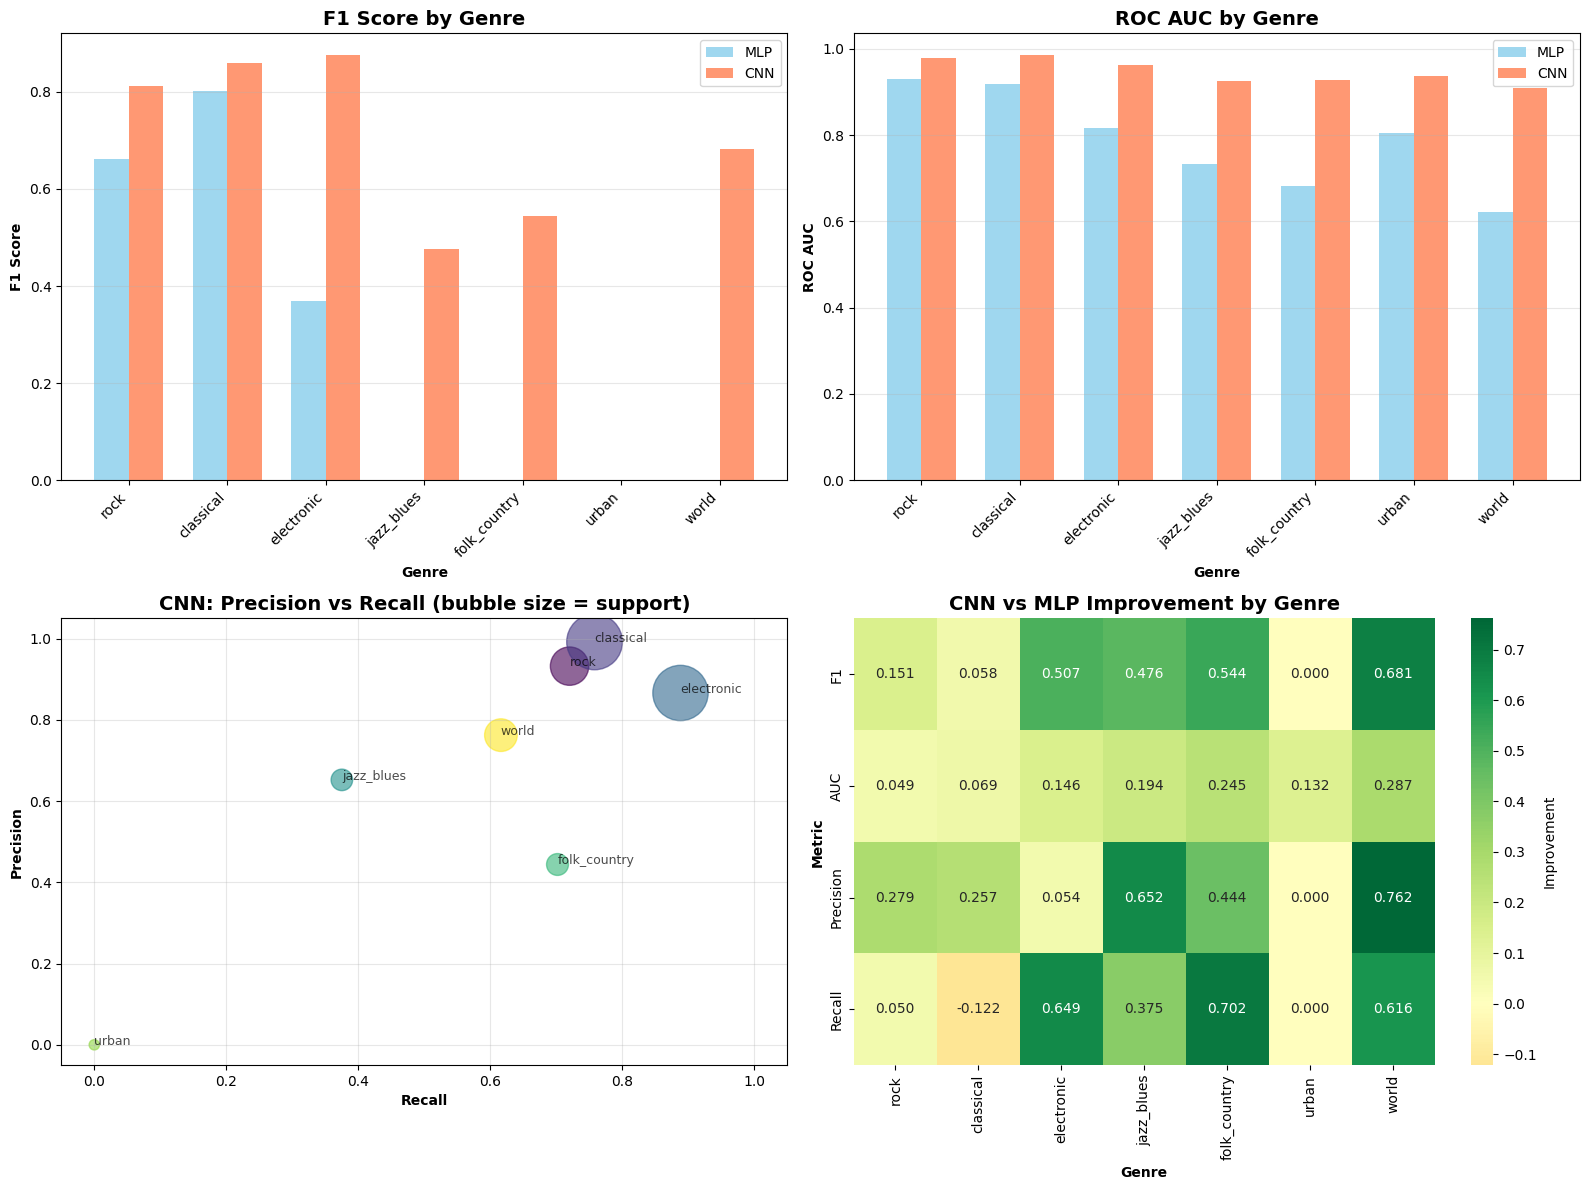

CNN co-occurrence plot saved to: /home/arjbah/Desktop/Coursework/ML/Lab3/logs/CNN_cooccurrence.png


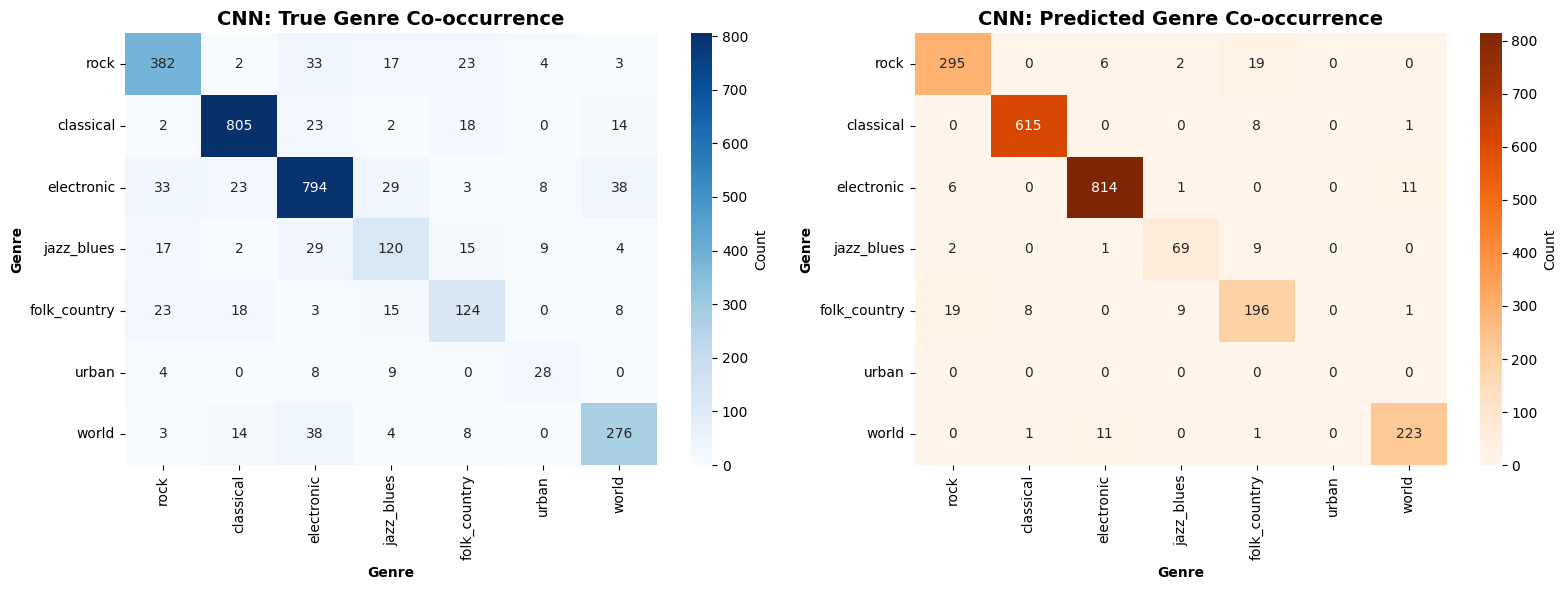


CONFIDENCE ANALYSIS

ROCK:
  Support: 382/2298 (16.6%)
  MLP - Avg confidence: 0.223 (pos: 0.494, neg: 0.169)
  CNN - Avg confidence: 0.158 (pos: 0.732, neg: 0.043)
  Performance - MLP F1: 0.661, CNN F1: 0.812 (Δ: +0.151)

CLASSICAL:
  Support: 805/2298 (35.0%)
  MLP - Avg confidence: 0.363 (pos: 0.623, neg: 0.223)
  CNN - Avg confidence: 0.266 (pos: 0.721, neg: 0.020)
  Performance - MLP F1: 0.801, CNN F1: 0.859 (Δ: +0.058)

ELECTRONIC:
  Support: 794/2298 (34.6%)
  MLP - Avg confidence: 0.381 (pos: 0.451, neg: 0.344)
  CNN - Avg confidence: 0.357 (pos: 0.832, neg: 0.107)
  Performance - MLP F1: 0.370, CNN F1: 0.877 (Δ: +0.507)

JAZZ_BLUES:
  Support: 120/2298 (5.2%)
  MLP - Avg confidence: 0.118 (pos: 0.164, neg: 0.116)
  CNN - Avg confidence: 0.085 (pos: 0.429, neg: 0.066)
  Performance - MLP F1: 0.000, CNN F1: 0.476 (Δ: +0.476)

FOLK_COUNTRY:
  Support: 124/2298 (5.4%)
  MLP - Avg confidence: 0.133 (pos: 0.163, neg: 0.131)
  CNN - Avg confidence: 0.121 (pos: 0.599, neg: 0.093)
  P

In [40]:
print("\n" + "=" * 60)
print("COMPUTING PER-GENRE METRICS")
print("=" * 60)

# MLP per-genre metrics
mlp_metrics, mlp_outputs, mlp_labels = evaluate_per_genre(
    mlp_model, test_loader, device, selected_tags, threshold=0.5
)
print_genre_metrics(mlp_metrics, "MLP BASELINE")

# CNN per-genre metrics
cnn_metrics, cnn_outputs, cnn_labels = evaluate_per_genre(
    cnn_model, test_loader, device, selected_tags, threshold=0.5
)
print_genre_metrics(cnn_metrics, "CNN")

# %% Plot per-genre comparisons
plot_genre_metrics(mlp_metrics, cnn_metrics, LOGS_DIR)

# %% Plot co-occurrence patterns
plot_confusion_heatmap(cnn_outputs, cnn_labels, selected_tags, 'CNN', LOGS_DIR)

# %% Additional Analysis: Confidence Analysis
print("\n" + "=" * 60)
print("CONFIDENCE ANALYSIS")
print("=" * 60)

for genre in selected_tags:
    mlp_m = mlp_metrics[genre]
    cnn_m = cnn_metrics[genre]
    
    print(f"\n{genre.upper()}:")
    print(f"  Support: {cnn_m['n_positive']}/{cnn_m['n_samples']} "
          f"({cnn_m['support_ratio']*100:.1f}%)")
    print(f"  MLP - Avg confidence: {mlp_m['avg_confidence']:.3f} "
          f"(pos: {mlp_m['avg_conf_positive']:.3f}, neg: {mlp_m['avg_conf_negative']:.3f})")
    print(f"  CNN - Avg confidence: {cnn_m['avg_confidence']:.3f} "
          f"(pos: {cnn_m['avg_conf_positive']:.3f}, neg: {cnn_m['avg_conf_negative']:.3f})")
    print(f"  Performance - MLP F1: {mlp_m['f1']:.3f}, CNN F1: {cnn_m['f1']:.3f} "
          f"(Δ: {cnn_m['f1']-mlp_m['f1']:+.3f})")

### Compare training history and save summaries

Training comparison plot saved to: /home/arjbah/Desktop/Coursework/ML/Lab3/logs/training_comparison.png


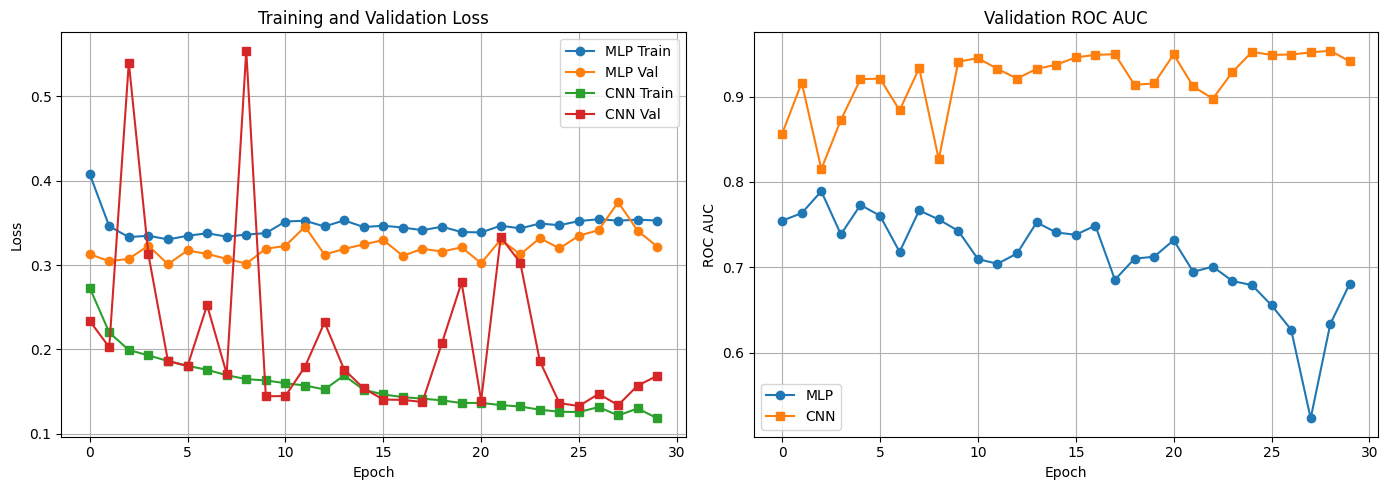


Results summary saved to: /home/arjbah/Desktop/Coursework/ML/Lab3/logs/genre_results_summary.txt

TRAINING COMPLETE!
All results saved to: /home/arjbah/Desktop/Coursework/ML/Lab3/logs


In [41]:
plot_training_history(history_mlp, history_cnn, LOGS_DIR)

save_results_summary(history_mlp, history_cnn, mlp_test_auc, cnn_test_auc,
                    mlp_test_loss, cnn_test_loss, LOGS_DIR, selected_tags)

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"All results saved to: {LOGS_DIR}")